In [106]:
import PIL
from PIL import Image, ImageDraw
import random
import networkx
import typing
import itertools

In [107]:
IMAGE_SIZE = (1200, 1200)
BOARD_SIZE = (15, 15)
OFFSET = (200, 200)
WALL_WIDTH = 3

In [108]:
board_coords = (
    OFFSET,
    (IMAGE_SIZE[0] - OFFSET[0], OFFSET[1]),
    (IMAGE_SIZE[0] - OFFSET[0], IMAGE_SIZE[1] - OFFSET[1]),
    (OFFSET[0], IMAGE_SIZE[1] - OFFSET[1])
)

cell_size = (
    (IMAGE_SIZE[0] - 2 * OFFSET[0]) / BOARD_SIZE[0],
    (IMAGE_SIZE[1] - 2 * OFFSET[1]) / BOARD_SIZE[1]
)

In [109]:
def get_cell_coords(x_num, y_num):
    return (
        (OFFSET[0] + cell_size[0] * x_num, OFFSET[1] + cell_size[1] * y_num),
        (OFFSET[0] + cell_size[0] * (x_num + 1), OFFSET[1] + cell_size[1] * y_num),
        (OFFSET[0] + cell_size[0] * (x_num + 1), OFFSET[1] + cell_size[1] * (y_num + 1)),
        (OFFSET[0] + cell_size[0] * x_num, OFFSET[1] + cell_size[1] * (y_num + 1))
    )

In [110]:
def create_empty_board_graph() -> networkx.Graph:
    g = networkx.Graph()
    for x in range(BOARD_SIZE[0]):
        for y in range(BOARD_SIZE[1]):
            g.add_node((x, y))
    
    for x1, x2 in zip(range(BOARD_SIZE[0] - 1), range(1, BOARD_SIZE[0])):
        for y in range(BOARD_SIZE[1]):
            g.add_edge((x1, y), (x2, y))
        
    for x in range(BOARD_SIZE[0]):
        for y1, y2 in zip(range(BOARD_SIZE[1] - 1), range(1, BOARD_SIZE[1])):
            g.add_edge((x, y1), (x, y2))
    
    return g


def generate_random_walls(g: networkx.Graph):
    for x1, x2 in zip(range(BOARD_SIZE[0] - 1), range(1, BOARD_SIZE[0])):
        for y in range(BOARD_SIZE[1]):
            has_wall = random.random() < 0.5
            if has_wall:
                g.remove_edge((x1, y), (x2, y))
    for x in range(BOARD_SIZE[0]):
        for y1, y2 in zip(range(BOARD_SIZE[1] - 1), range(1, BOARD_SIZE[1])):
            has_wall = random.random() < 0.5
            if has_wall:
                g.remove_edge((x, y1), (x, y2))

                
def add_walls_to_remove_cycles(g):
    while True:
        try:
            cycle = networkx.find_cycle(g)
        except networkx.NetworkXNoCycle:
            break
            
        g.remove_edge(*random.choice(cycle))
        
        
def remove_walls_to_connect_all_components(g: networkx.Graph):
    empty_g = create_empty_board_graph()
    uf = networkx.utils.union_find.UnionFind(g.nodes)
    for c1, c2 in g.edges:
        uf.union(c1, c2)

    while True:
        components = list(uf.to_sets())
        if len(components) == 1:
            break

        merging_component = components.pop()
        neighbors = set.union(*(
            set(empty_g.neighbors(cell))
            for cell in merging_component
        ))
        foreign_neighbors = neighbors - merging_component

        merging_component_borders = set(empty_g.subgraph(merging_component | foreign_neighbors).edges)
        merging_component_borders -= empty_g.subgraph(merging_component).edges
        merging_component_borders -= empty_g.subgraph(foreign_neighbors).edges

        destroying_wall = random.choice(list(merging_component_borders))
        g.add_edge(*destroying_wall)
        uf.union(*destroying_wall)


def find_longest_crossing_path(
    g: networkx.Graph
) -> typing.List[typing.Tuple[int, int]]:    
    border_cells = set.union(
        {(x, 0) for x in range(BOARD_SIZE[0])},
        {(x, BOARD_SIZE[1] - 1) for x in range(BOARD_SIZE[0])},
        {(0, y) for y in range(BOARD_SIZE[1])},
        {(BOARD_SIZE[0] - 1, y) for y in range(BOARD_SIZE[1])},
    )

    longest_path = list()
    for c1, c2 in itertools.combinations(border_cells, 2):
        paths = networkx.all_simple_paths(g, c1, c2)

        this_longest_path = max(paths, key=len)
        if len(this_longest_path) > len(longest_path):
            longest_path = this_longest_path

    return longest_path

In [115]:
def _draw_grid(d: ImageDraw.Draw):
    for x in range(1, BOARD_SIZE[0]):
        d.line(
            [
                get_cell_coords(x, 0)[0],
                get_cell_coords(x, BOARD_SIZE[1] - 1)[3]
            ],
            fill='lightgray'
        )
    
    for y in range(1, BOARD_SIZE[1]):
        d.line(
            [
                get_cell_coords(0, y)[0],
                get_cell_coords(BOARD_SIZE[0] - 1, y)[1]
            ],
            fill='lightgray'
        )
        

def _draw_walls(d: ImageDraw.Draw, g: networkx.Graph):
    empty_g = create_empty_board_graph()
    walls = set(empty_g.edges) - set(g.edges)
    
    for (x1, y1), (x2, y2) in walls:
        if x1 == x2:
            x = x1
            
            d.line(
                [
                    get_cell_coords(x, y1)[2],
                    get_cell_coords(x, y1)[3]
                ],
                fill='black',
                width=WALL_WIDTH
            )
        if y1 == y2:
            y = y1
            
            d.line(
                [
                    get_cell_coords(x1, y)[1],
                    get_cell_coords(x1, y)[2]
                ],
                fill='black',
                width=WALL_WIDTH
            )
            

def _erase_walls_from_entrance(
    d: ImageDraw.Draw,
    g: networkx.Graph, 
    c1: typing.Tuple[int, int], 
    c2: typing.Tuple[int, int]
):
    for cell in c1, c2:
        if cell[0] == 0:  # on a right side
            d.line(
                [
                    get_cell_coords(*cell)[0],
                    get_cell_coords(*cell)[3]
                ],
                fill='white',
                width=WALL_WIDTH + 1
            )
        
        elif cell[0] == BOARD_SIZE[0] - 1:  # on a left side
            d.line(
                [
                    get_cell_coords(*cell)[1],
                    get_cell_coords(*cell)[2]
                ],
                fill='white',
                width=WALL_WIDTH + 1
            )
            
        if cell[1] == 0:  # on a top side
            d.line(
                [
                    get_cell_coords(*cell)[0],
                    get_cell_coords(*cell)[1]
                ],
                fill='white',
                width=WALL_WIDTH + 1
            )
        
        elif cell[1] == BOARD_SIZE[1] - 1:  # on a bottom side
            d.line(
                [
                    get_cell_coords(*cell)[2],
                    get_cell_coords(*cell)[3]
                ],
                fill='white',
                width=WALL_WIDTH + 1
            )
            


def _draw_path(
    d: ImageDraw.Draw,
    g: networkx.Graph,
    path: typing.List[typing.Tuple[int , int]]
):
    for cell in path:
        coords = get_cell_coords(*cell)
        d.polygon(coords, fill='yellow', width=0)


def draw_board(
        g: networkx.Graph, 
        path: typing.Optional[typing.List[typing.Tuple[int , int]]] = None,
        draw_path: bool = True
):
    img = Image.new('RGB', IMAGE_SIZE, (255, 255, 255))
    d = ImageDraw.Draw(img)

    if draw_path and path is not None:
        _draw_path(d, g, path)
    
    _draw_grid(d)
    d.polygon(board_coords, outline='black', width=WALL_WIDTH)

    _draw_walls(d, g)
    
    if path is not None:
        _erase_walls_from_entrance(d, g, path[0], path[-1])
        
    # img.save('my_labyrinth.png')
    display(img)

# GENERATE LABYRINTH

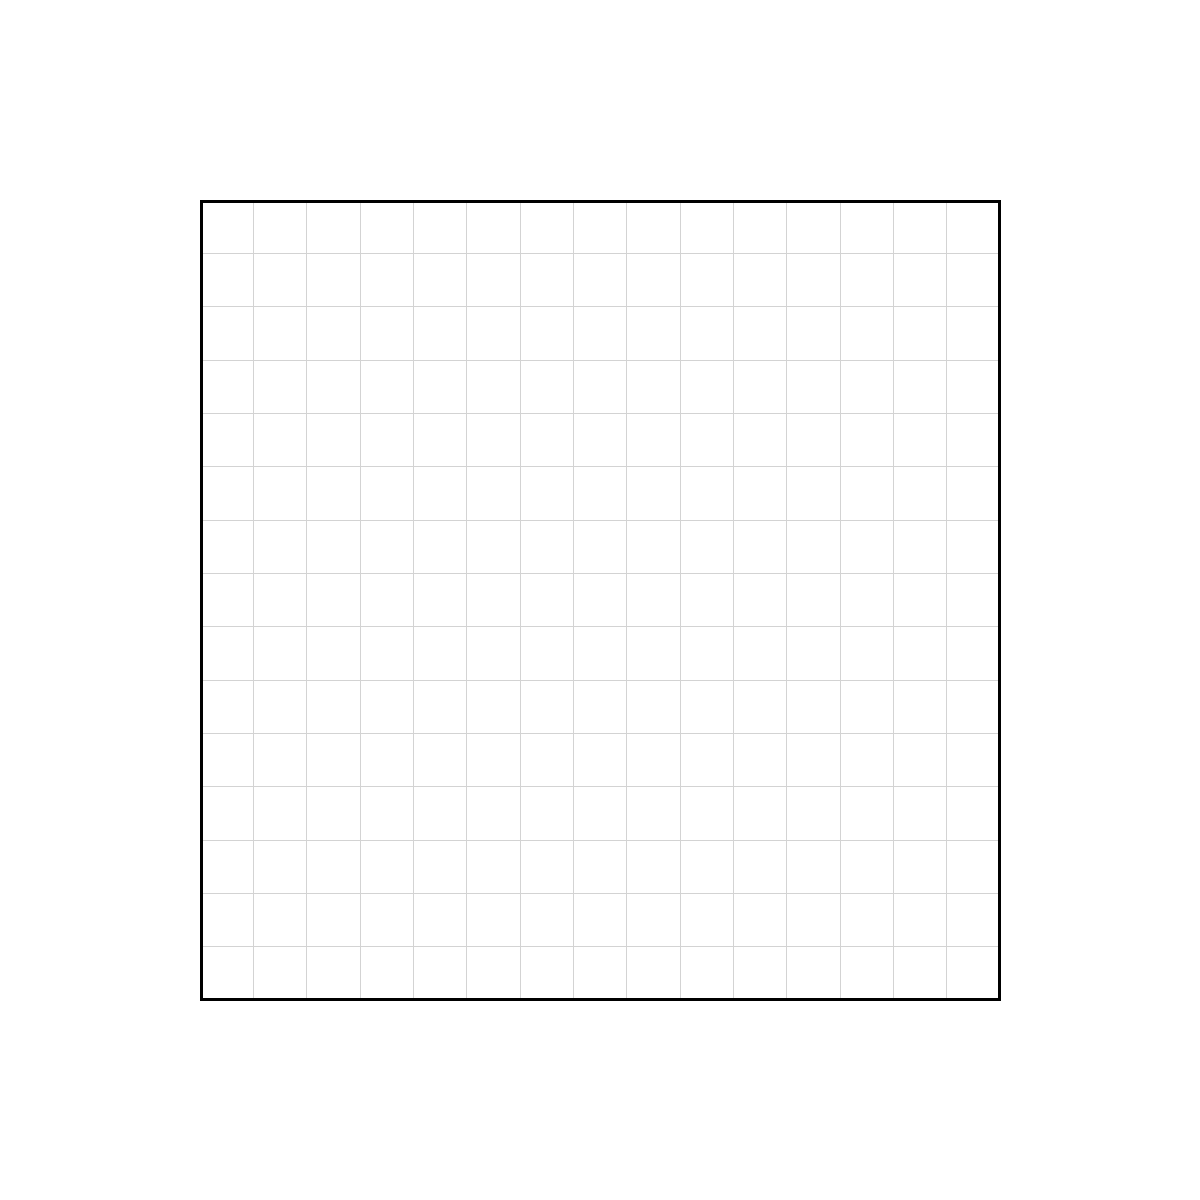

In [122]:
g = create_empty_board_graph()

draw_board(g)

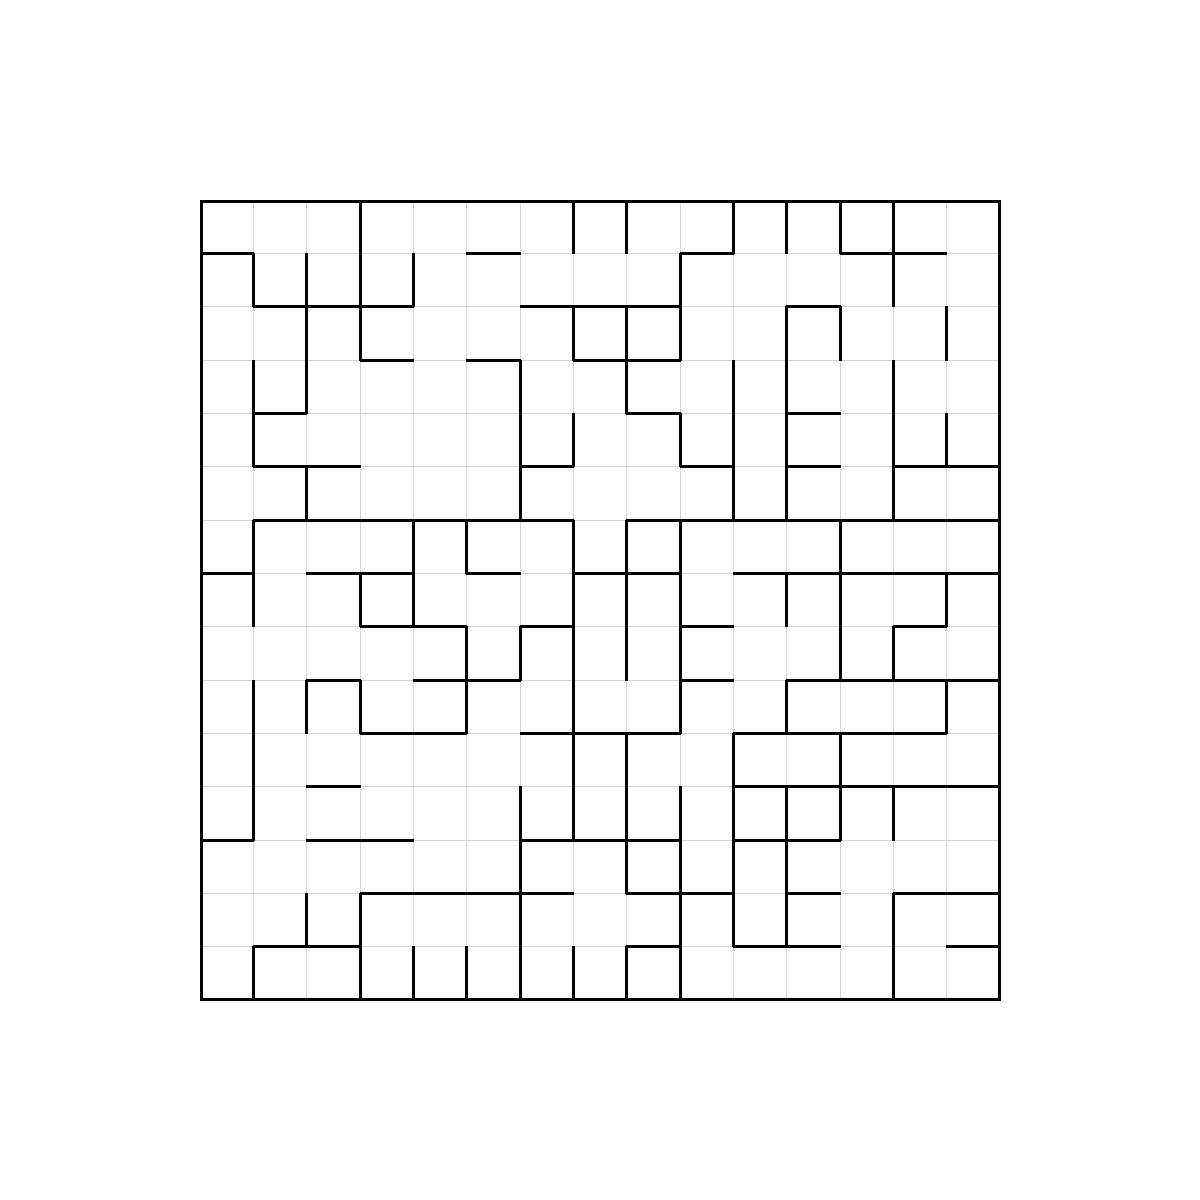

In [123]:
generate_random_walls(g)

draw_board(g)

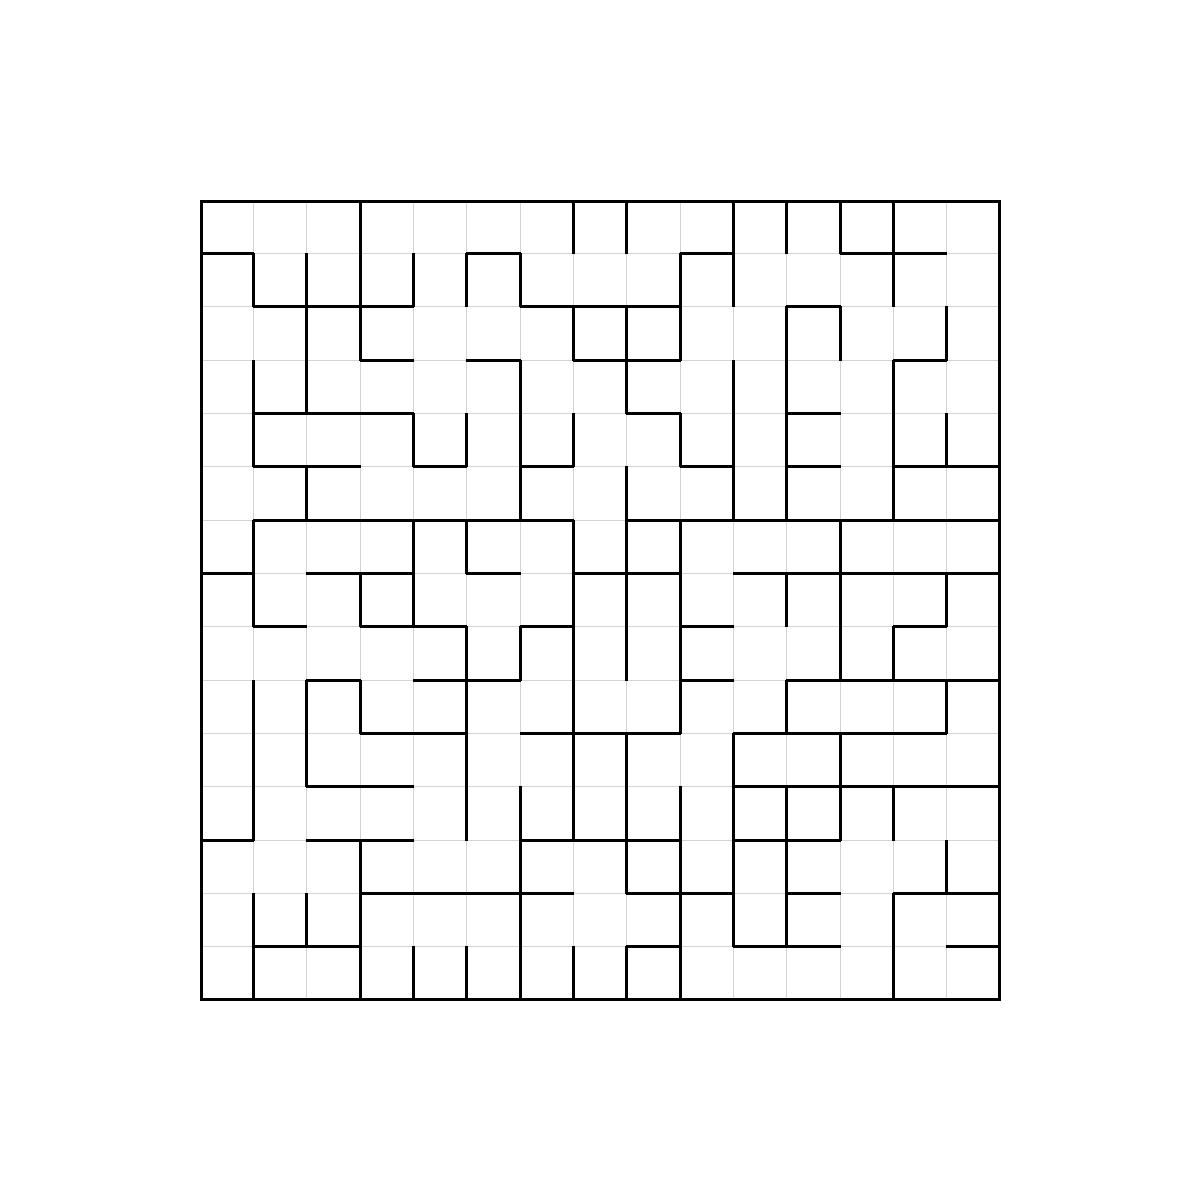

In [124]:
add_walls_to_remove_cycles(g)

draw_board(g)

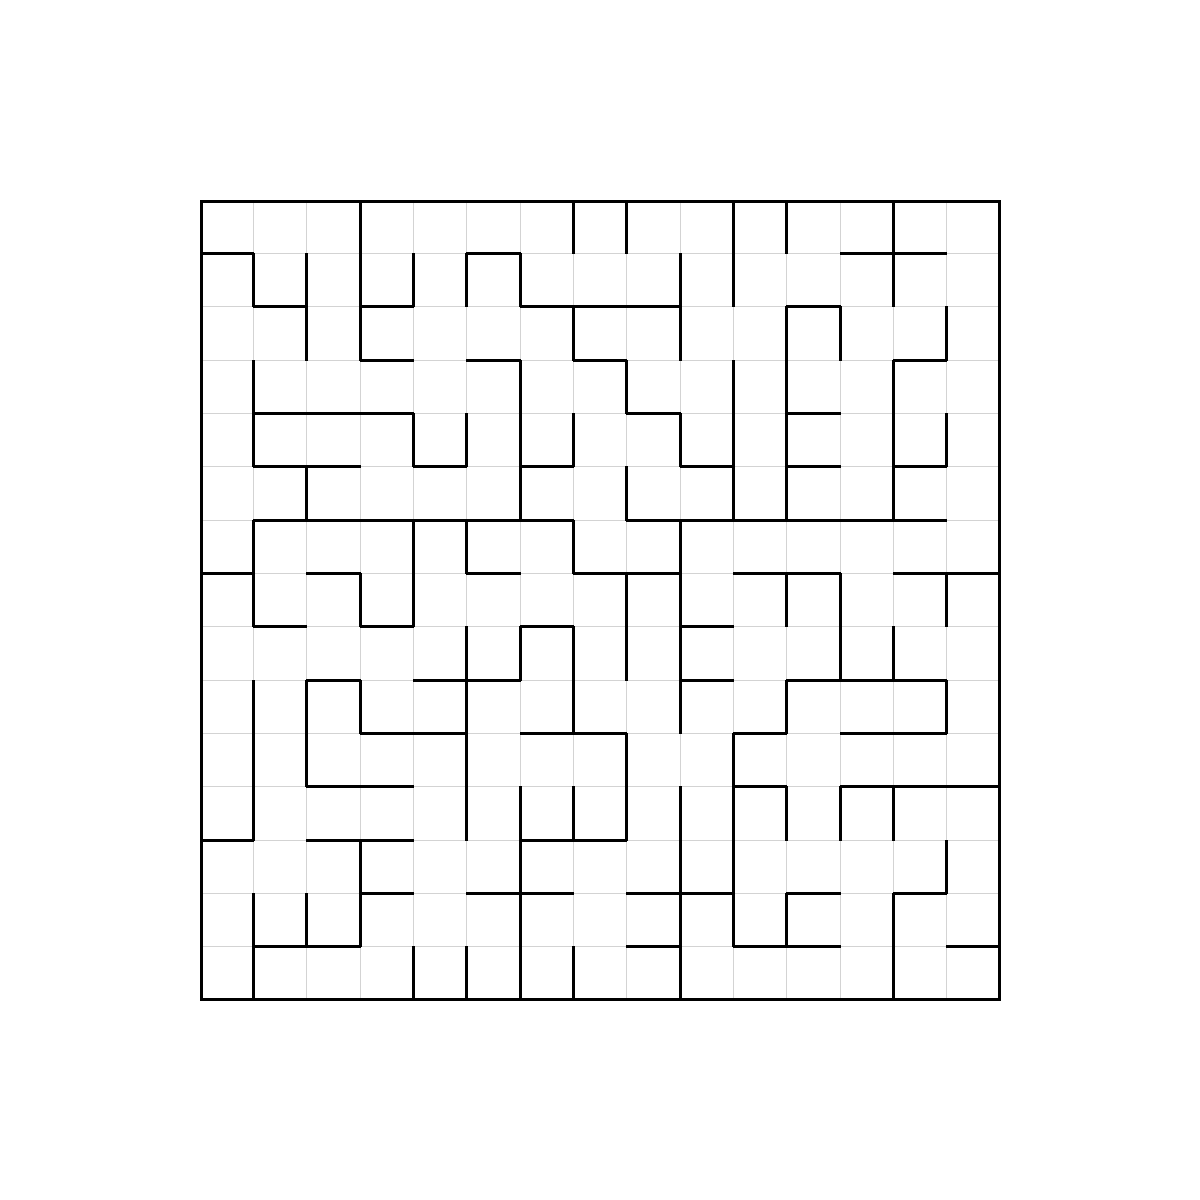

In [125]:
remove_walls_to_connect_all_components(g)

draw_board(g)

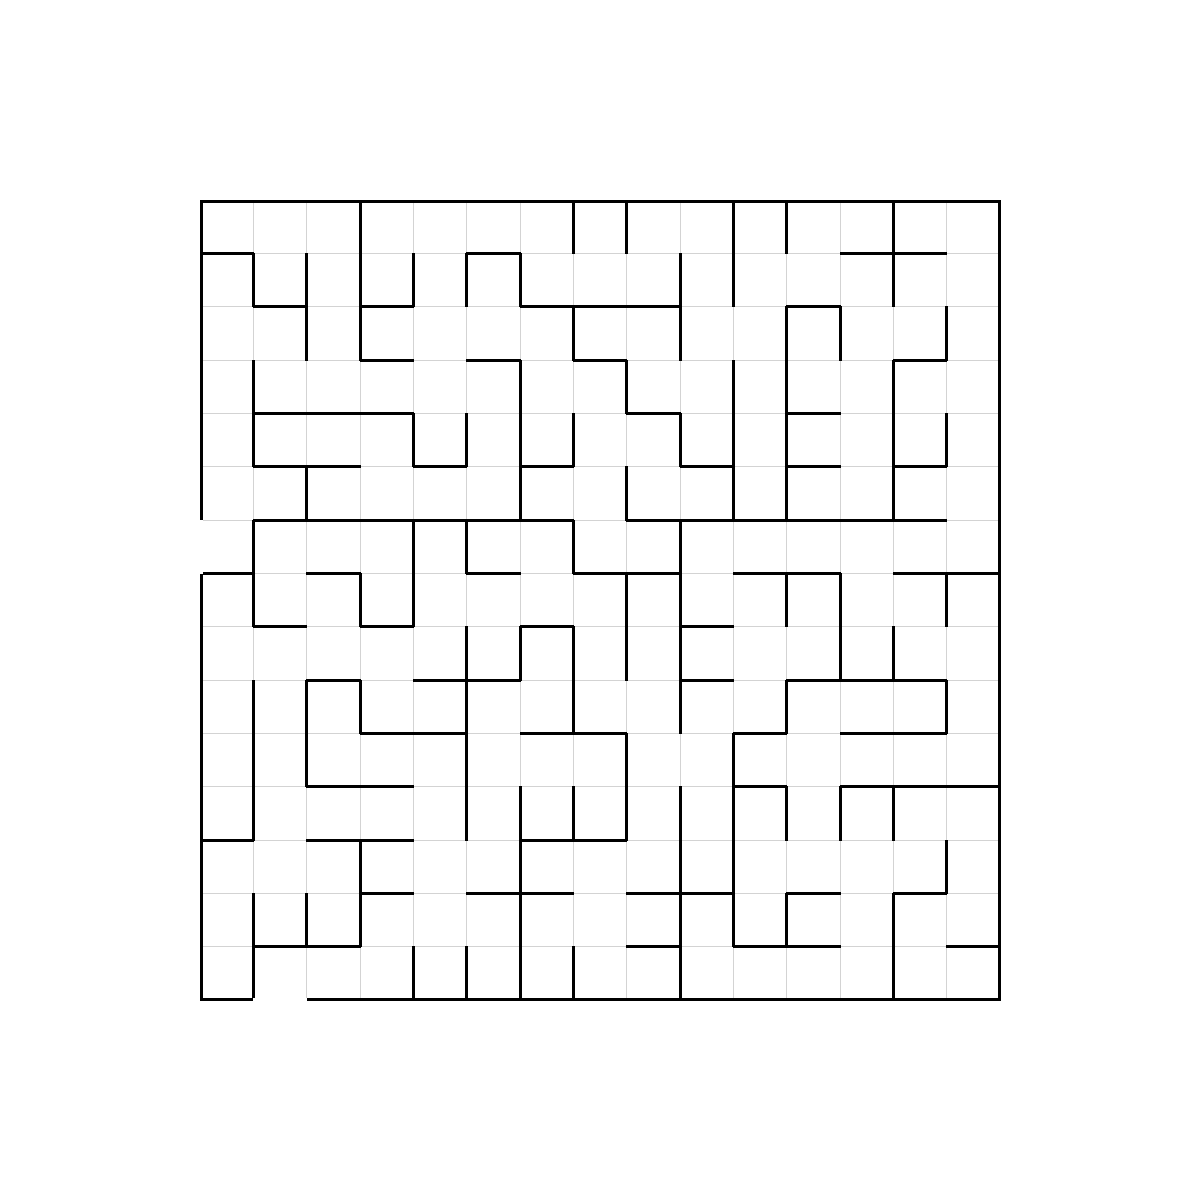

In [126]:
path = find_longest_crossing_path(g)

draw_board(g, path, draw_path=False)

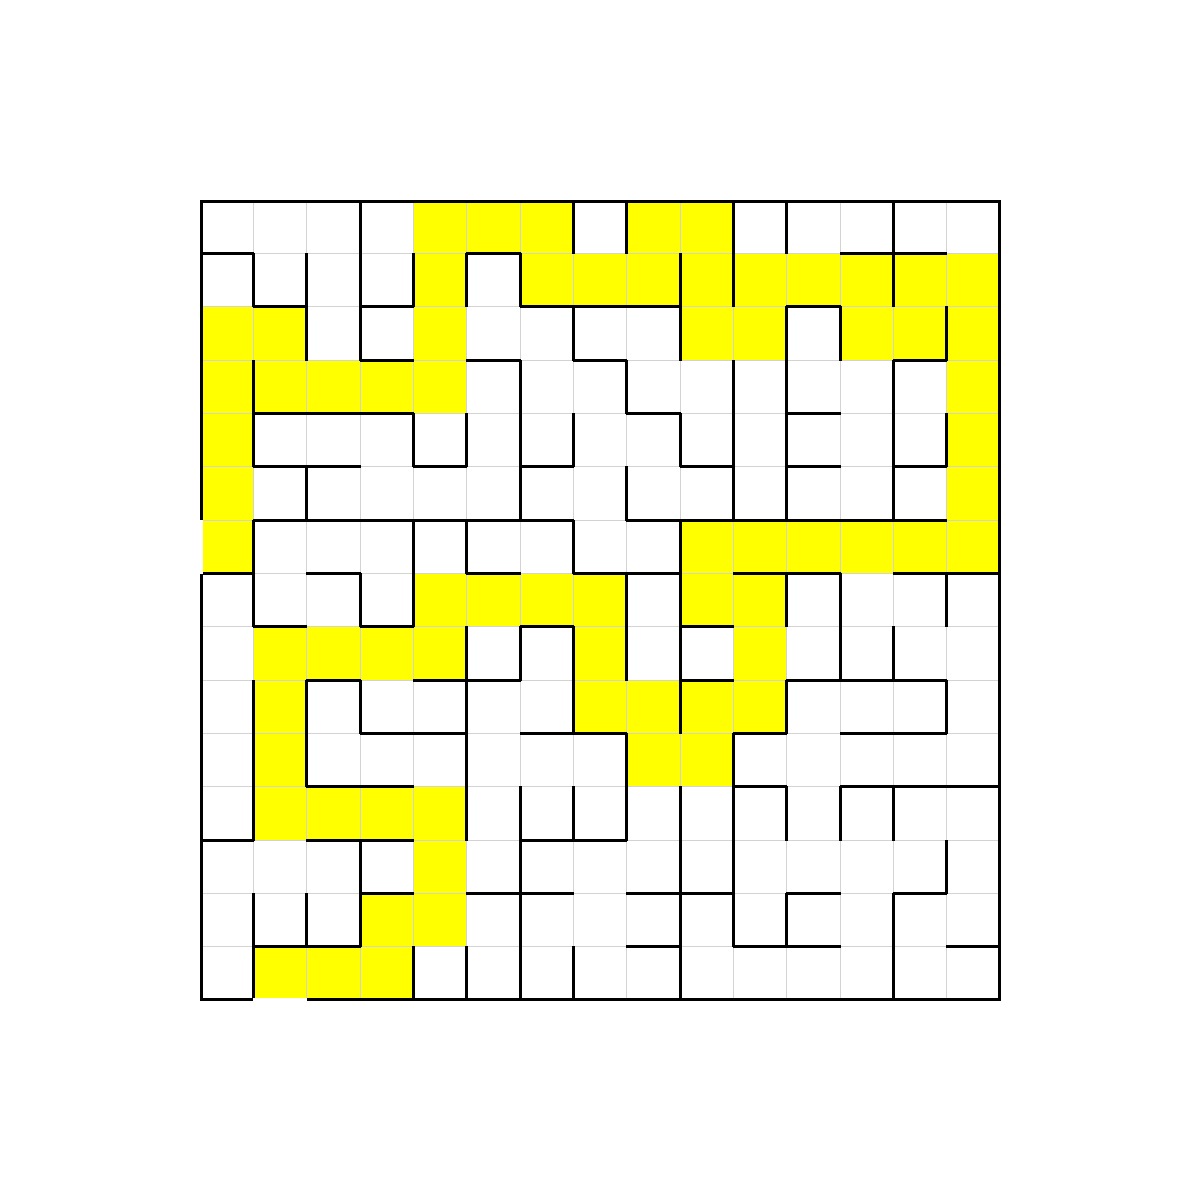

In [127]:
draw_board(g, path)